# Import Library 

In [1]:
from ucimlrepo import list_available_datasets
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from sklearn.feature_selection import f_regression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error



import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold

from statsmodels.tools.tools import add_constant


from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)


from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

## Step 1: Upload Dataset 

In [2]:
dataset_name = "Appliances Energy Prediction"
dataset = fetch_ucirepo(name=dataset_name)

# Convert features and target to DataFrame
df = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

# Step 1: Fix dashes
df['date'] = df['date'].str.replace('–', '-', regex=False)

# Step 2: Insert a 'T' between date and time
df['date'] = df['date'].str.replace(r'(\d{4}-\d{2}-\d{2})(\d{2}:\d{2}:\d{2})', r'\1T\2', regex=True)

# Step 3: Convert to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S')

In [3]:
# Drop columns 
df = df.drop(columns=['lights'])

In [4]:
# Extracting Features from the datetime column
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['day_name'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name()
df['day_of_month'] = df['date'].dt.day

In [5]:
# Define the face of the day 
def face_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column
df['face_of_day'] = df['hour'].apply(face_of_day)

In [6]:
df.head( )

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,rv2,Appliances,hour,day,day_of_week,day_name,month,month_name,day_of_month,face_of_day
0,2016-01-11 17:00:00,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,13.275433,60,17,11,0,Monday,1,January,11,Afternoon
1,2016-01-11 17:10:00,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,18.606195,60,17,11,0,Monday,1,January,11,Afternoon
2,2016-01-11 17:20:00,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,28.642668,50,17,11,0,Monday,1,January,11,Afternoon
3,2016-01-11 17:30:00,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,45.410390,50,17,11,0,Monday,1,January,11,Afternoon
4,2016-01-11 17:40:00,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,10.084097,60,17,11,0,Monday,1,January,11,Afternoon


In [7]:
# Define numerical, categorical features, and dependent feature
numerical_features = [ 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6',
'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
'Windspeed', 'Visibility','Tdewpoint', 'rv1', 'rv2', 'hour', 'day_of_month'] 
categorical_features = ['day_name', 'month_name', 'face_of_day']
dependent_feature = 'Appliances'


# Step 2: Feature Engineering 

In [8]:
df = df.drop(columns=['date'])

In [9]:
def cap_outliers_IQR(df, columns):
    df_capped = df.copy()
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap outliers
        df_capped[col] = df_capped[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
        
    return df_capped


In [10]:
# Assuming `numerical_features` list is already defined (from previous step)
df = cap_outliers_IQR(df, numerical_features)

#### Encoding Categorical Variables

In [11]:
df_processed= pd.get_dummies(df, columns=categorical_features, drop_first=True)
# convert boolean columns to integers
df_processed = df_processed.astype({col: int for col in df_processed.select_dtypes('bool').columns})
df_processed.head()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,month_name_February,month_name_January,month_name_March,month_name_May,face_of_day_Evening,face_of_day_Morning,face_of_day_Night
0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,...,0,0,0,0,1,0,0,0,0,0
1,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,...,0,0,0,0,1,0,0,0,0,0
2,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,...,0,0,0,0,1,0,0,0,0,0
3,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,...,0,0,0,0,1,0,0,0,0,0
4,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,...,0,0,0,0,1,0,0,0,0,0


In [12]:
df_processed.shape

(19735, 45)

# Step 3: Split Data into Train and Test Sets

### Step 1: Spit Datasets

In [13]:
X = df_processed.drop(columns=[dependent_feature])
y = df_processed[dependent_feature]

# X = full feature set (all columns), y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15788, 44), (3947, 44), (15788,), (3947,))

### Step 2: Variance Threshold (on training data only)

In [15]:
# Apply on training data only
var_thresh = 0.01
var_selector = VarianceThreshold(threshold=var_thresh)
X_train_var = var_selector.fit_transform(X_train)
X_test_var = var_selector.transform(X_test)  # Apply the same transformation


In [16]:
# Get selected column names
selected_var_cols = X_train.columns[var_selector.get_support()]
X_train_var = pd.DataFrame(X_train_var, columns=selected_var_cols)
X_test_var = pd.DataFrame(X_test_var, columns=selected_var_cols)

### Step 3: F-value Feature Selection (on variance-filtered train set)

In [17]:
# Compute F-values
f_vals, p_vals = f_regression(X_train_var, y_train)

# Create DataFrame of results
anova_df = pd.DataFrame({
    'Feature': selected_var_cols,
    'F_value': f_vals,
    'p_value': p_vals
})

# Choose F-value threshold
f_threshold = 30
selected_f_cols = anova_df[anova_df['F_value'] > f_threshold]['Feature']

# Final feature sets
X_train_features= X_train_var[selected_f_cols]
X_test_features = X_test_var[selected_f_cols]


In [18]:
X_train_features.head()

,T1,RH_1,T2,RH_2,T3,T6,RH_6,RH_7,RH_8,RH_9,T_out,RH_out,Windspeed,hour,day_name_Tuesday,face_of_day_Evening,face_of_day_Night
0,19.89,45.50,19.200000,45.090000,20.390000,11.100000,98.433333,43.50,50.000000,48.700000,10.300,85.500000,7.500000,12.0,1.0,0.0,0.0
1,25.36,46.56,25.565000,42.025714,27.040000,22.700000,1.000000,44.50,50.074000,46.790000,20.495,55.666667,3.333333,17.0,0.0,0.0,0.0
2,22.50,44.43,21.533333,42.590000,21.963333,6.530000,61.463333,34.32,41.331111,45.530000,6.600,64.000000,8.000000,13.0,0.0,0.0,0.0
3,19.79,38.06,17.200000,40.933333,20.600000,2.790000,79.933333,32.00,42.590000,40.723333,2.100,94.333333,1.000000,9.0,0.0,0.0,0.0
4,20.60,35.29,17.100000,39.790000,20.290000,-0.666667,68.530000,33.59,39.260000,40.090000,-0.867,92.333333,1.666667,4.0,0.0,0.0,1.0


In [19]:
X_test_features.head()

,T1,RH_1,T2,RH_2,T3,T6,RH_6,RH_7,RH_8,RH_9,T_out,RH_out,Windspeed,hour,day_name_Tuesday,face_of_day_Evening,face_of_day_Night
0,20.890000,35.400000,17.760000,39.163333,20.290000,1.198571,63.817857,33.663333,39.747500,39.03,1.770,88.333333,2.333333,1.0,0.0,0.0,1.0
1,21.890000,51.666667,21.290000,45.360000,21.633333,2.530000,97.090000,39.345000,47.563333,44.20,2.700,90.000000,3.000000,20.0,0.0,1.0,0.0
2,21.390000,35.500000,17.633333,40.530000,21.666667,-0.266667,50.930000,27.290000,39.626667,38.29,0.200,83.000000,2.000000,3.0,1.0,0.0,1.0
3,21.390000,41.033333,23.890000,34.840000,22.033333,11.160000,10.296667,30.390000,38.090000,38.56,8.850,70.833333,5.166667,10.0,0.0,0.0,0.0
4,19.963333,35.126667,16.463333,40.126667,20.000000,-0.733333,71.230000,34.060000,39.590000,40.70,-0.467,93.333333,4.000000,8.0,0.0,0.0,0.0


### Step 4: Standardize Data

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

### Step 4: Training Multiple Linear Regression Model 

In [21]:
model = LinearRegression()


# Cross-validated RMSE (neg_root_mean_squared_error returns negative so we take -mean)
scores = cross_val_score(model, X_train_scaled, y_train, 
                         scoring='neg_root_mean_squared_error', cv=10)

cv_rmse = -np.mean(scores)
print(f"10-Fold CV RMSE: {cv_rmse:.2f}")

10-Fold CV RMSE: 95.21


In [22]:
scores

array([ -91.66283331, -110.15777577,  -94.00676812,  -99.92528252,
        -87.34867554,  -96.9490184 ,  -97.61343711,  -85.44157572,
        -97.67123819,  -91.28063258])

In [23]:
results = model.fit(X_train_scaled, y_train)

In [24]:
y_pred = model.predict(X_test_scaled)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 92.75
MAE: 54.45
R² Score: 0.14
MAPE: 66.96%


In [26]:
def train_ols(X_train, y_train):
    X_train_const = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_const)
    return model.fit()

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE": mape}

In [27]:
train_ols(X_train_scaled, y_train)
results = train_ols(X_train_scaled, y_train)
summarize(results)

,coef,std err,t,P>|t|
const,97.9497,0.759,129.060,0.000
x1,9.3510,3.121,2.996,0.003
x2,68.2642,2.702,25.261,0.000
x3,-42.7536,3.470,-12.321,0.000
x4,-55.4093,2.892,-19.160,0.000
x5,36.9577,2.277,16.232,0.000
x6,33.7965,4.626,7.306,0.000
x7,20.2788,2.164,9.370,0.000
x8,-10.7882,2.119,-5.091,0.000
x9,-9.0677,2.058,-4.407,0.000


## Ridge Regression

In [29]:

#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
ridge_model= RidgeCV(alphas=np.arange(0.01, 1.0, 0.01) , cv=cv, scoring='neg_mean_absolute_error')

#fit model
ridge_model.fit(X_train_scaled, y_train)


y_pred = ridge_model.predict(X_test_scaled)

#display lambda that produced the lowest test MSE
print(ridge_model.alpha_)


0.99


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred_ridge = ridge_model.predict(X_test_scaled)

rmse_ridge= np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge= mean_absolute_error(y_test, y_pred_ridge)
r2_ridge= r2_score(y_test, y_pred_ridge)
mape_ridge= np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100

print(f"Ridge RMSE: {rmse_ridge:.2f}")
print(f"Ridge MAE: {mae_ridge:.2f}")
print(f"Ridge R²: {r2_ridge:.2f}")
print(f"Ridge MAPE: {mape_ridge:.2f}%")


Ridge RMSE: 92.75
Ridge MAE: 54.45
Ridge R²: 0.14
Ridge MAPE: 66.95%


<Axes: >

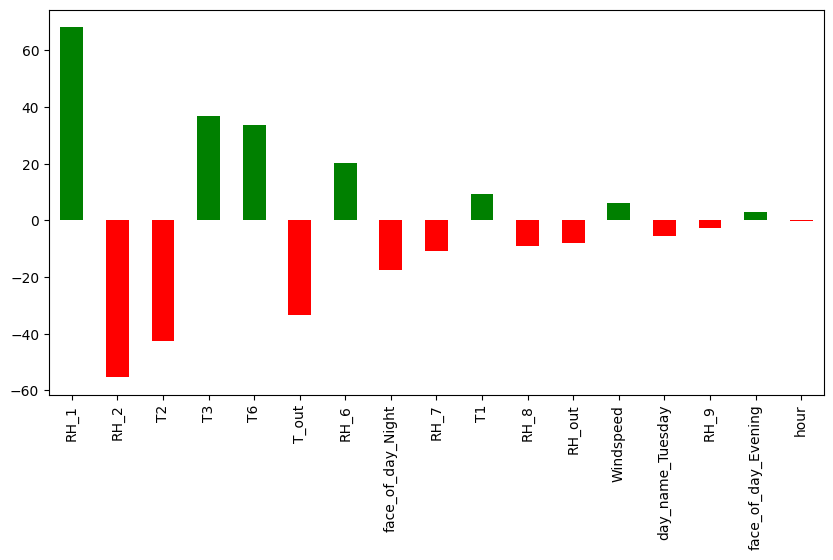

In [ ]:
feature_names = X_train_features.columns  # or a list like ['hour', 'T2', 'RH_1', ...]
coef_series = pd.Series(ridge_model.coef_, index=feature_names)
coef_series = coef_series.sort_values(key=abs, ascending=False)
colors = ['green' if val > 0 else 'red' for val in coef_series]
#coef_series.plot(kind='bar', color=colors, figsize=(12, 6))

coef_series.plot(kind='bar', figsize=(10, 5), color=colors)


## Lasso 

In [32]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import numpy as np

In [33]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

lasso_model = LassoCV(alphas=np.arange(0.001, 1.0, 0.01), 
                      cv=cv, 
                      random_state=1, 
                      max_iter=10000)

In [34]:
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [35]:
print(f"Best alpha selected: {lasso_model.alpha_:.4f}")


Best alpha selected: 0.0110


In [36]:
y_pred_lasso = lasso_model.predict(X_test_scaled)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mape_lasso= np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100

print(f"Lasso RMSE: {rmse_lasso:.2f}")
print(f"Lasso MAE: {mae_lasso:.2f}")
print(f"Lasso R²: {r2_lasso:.2f}")
print(f"Lasso MAPE: {mape_lasso:.2f}%")


Lasso RMSE: 92.74
Lasso MAE: 54.44
Lasso R²: 0.14
Lasso MAPE: 66.95%


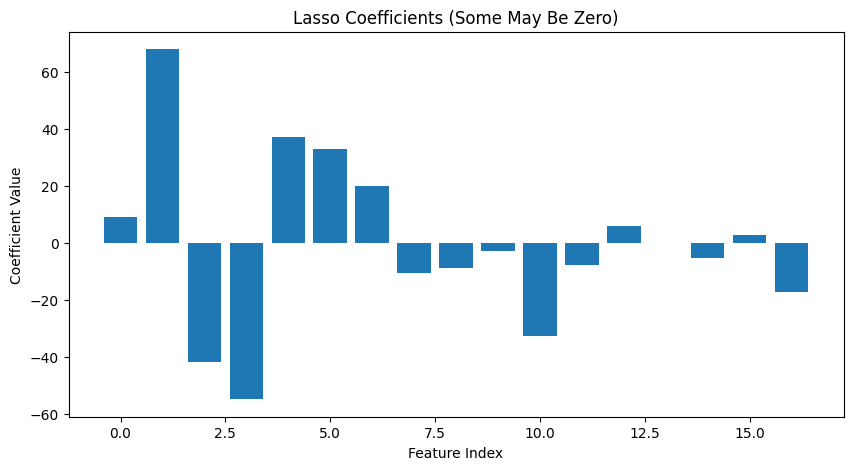

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(len(lasso_model.coef_)), lasso_model.coef_)
plt.title('Lasso Coefficients (Some May Be Zero)')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.show()


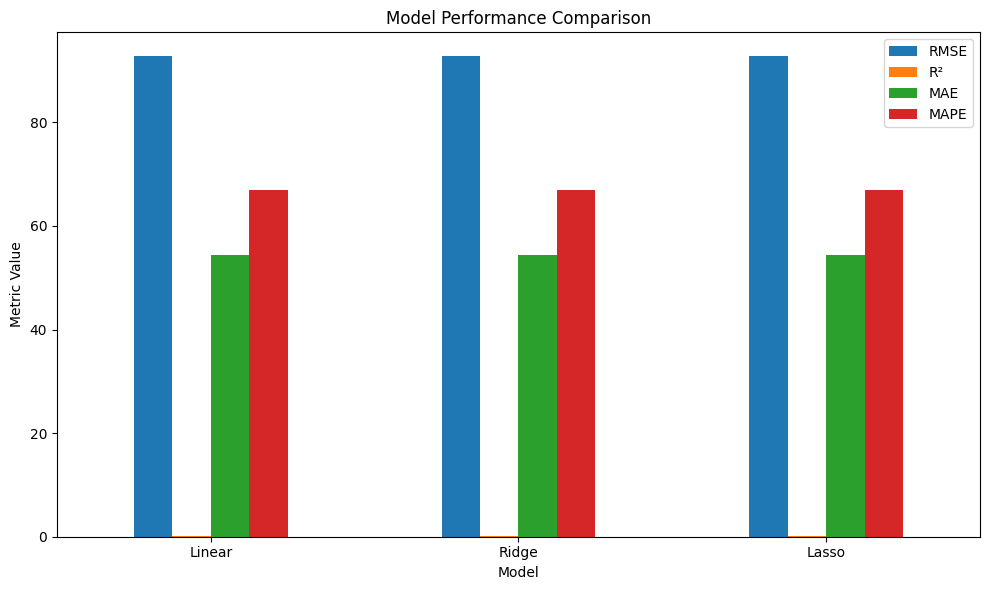

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_df = pd.DataFrame({
    'Model': ['Linear', 'Ridge', 'Lasso'],
    'RMSE': [rmse, rmse_ridge, rmse_lasso],
    'R²': [r2, r2_ridge, r2_lasso],
    'MAE': [mae, mae_ridge, mae_lasso],
    'MAPE': [mape, mape_ridge, mape_lasso]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Decision Tree  Regressor 

In [39]:
from sklearn.tree import DecisionTreeRegressor

# Initialize with optional hyperparameters
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)

In [40]:
tree_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [41]:
y_pred_tree = tree_model.predict(X_test_scaled)
y_pred_tree

array([ 44.77513228, 131.5172956 ,  49.63235294, ...,  88.88004548,
        80.54216867, 127.73888363])

In [42]:
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree= r2_score(y_test, y_pred_tree)
mape_tree = np.mean(np.abs((y_test - y_pred_tree) / y_test)) * 100

print(f"Tree RMSE: {rmse_tree:.2f}")
print(f"Tree MAE: {mae_tree:.2f}")
print(f"Tree R²: {r2_tree:.2f}")
print(f"Tree MAPE: {mape_tree:.2f}%")


Tree RMSE: 90.72
Tree MAE: 50.00
Tree R²: 0.18
Tree MAPE: 58.58%


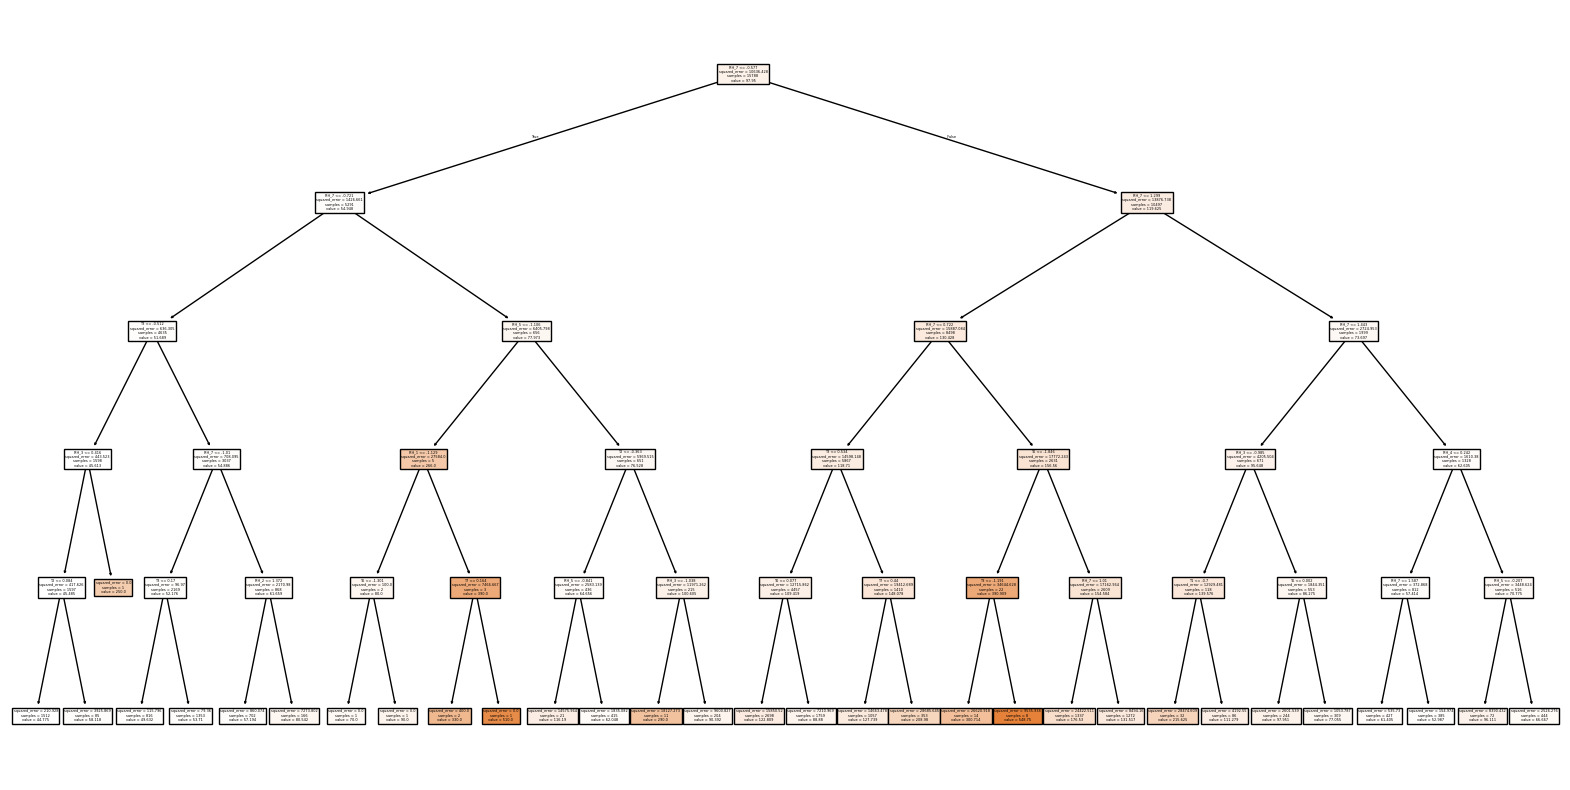

In [43]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(tree_model, filled=True, feature_names=X.columns)  # if using DataFrame
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(DecisionTreeRegressor(), params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train_scaled, y_train)
print("Best params:", grid.best_params_)


Best params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [45]:
grid_pred = grid.predict(X_test_scaled)

In [46]:
rmse_grid = np.sqrt(mean_squared_error(y_test, grid_pred))
mae_grid  = mean_absolute_error(y_test, grid_pred)
r2_grid = r2_score(y_test, grid_pred)
mape_grid = np.mean(np.abs((y_test - grid_pred) / y_test)) * 100

print(f"Tree RMSE: {rmse_grid:.2f}")
print(f"Tree MAE: {mae_grid:.2f}")
print(f"Tree R²: {r2_grid:.2f}")
print(f"Tree MAPE: {mape_grid:.2f}%")

Tree RMSE: 85.04
Tree MAE: 37.94
Tree R²: 0.28
Tree MAPE: 35.65%


## Random Forest 

In [47]:
from sklearn.ensemble import RandomForestRegressor

# Initialize model with common defaults
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [48]:
y_pred_rf = rf_model.predict(X_test_scaled)

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse_rf= np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf= mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")
print(f"Random Forest MAPE: {mape_rf:.2f}%")


Random Forest RMSE: 63.10
Random Forest MAE: 29.55
Random Forest R²: 0.60
Random Forest MAPE: 29.54%
